In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
census_database_path = "../Desktop/hawaii.sqlite"
engine = create_engine(f"sqlite:///{census_database_path}")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [11]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_year_data = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_year_data)

('2017-08-23',)


In [16]:
# Calculate the date 1 year ago from the last data point in the database

year_prior = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_prior)

2016-08-23


In [18]:
# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_prior).\
    order_by(Measurement.date).all()

In [19]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_scores_df = pd.DataFrame(precipitation_scores)
precipitation_scores_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [20]:
# Sort the dataframe by date
precipitation_scores_df = pd.DataFrame(precipitation_scores)
precipitation_scores_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


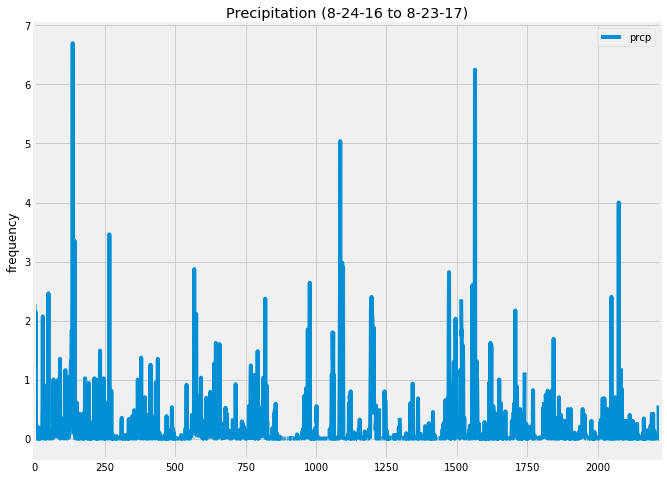

In [24]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_scores_df.plot(figsize=(10,8))
ax.set_title("Precipitation (8-24-16 to 8-23-17)")
ax.set_ylabel('frequency')
plt.show()

![precipitation](Images/precipitation.png)

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_scores_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [25]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement).group_by(Measurement.station).count()
print("The total amount of available stations is {}.".format(available_stations))

The total amount of available stations is 9.


In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in station_count:
    print(f"Station: {result[0]}\tCount: {result[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = 'USC00519281'
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")

Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

#save as a data frame
last_year_temps_df = pd.DataFrame(last_year_temps, columns = ['date', 'temperature'])
last_year_temps_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


In [31]:
last_year_temps_df.set_index('date', inplace = True)

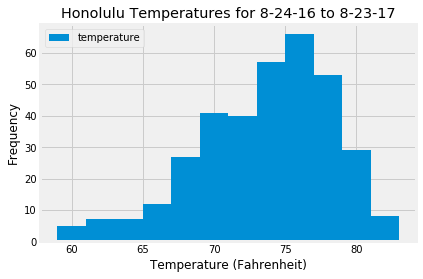

In [38]:
fig, ax = plt.subplots()
last_year_temps_df.plot.hist(bins = 12, ax = ax)

ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("Honolulu Temperatures for 8-24-16 to 8-23-17")
plt.show()

![precipitation](Images/station-histogram.png)

In [39]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-01-04', '2017-01-18')

print(f"Min Temp: {trip_temps[0][0]} Fahrenheit")
print(f"Avg Temp: {round(trip_temps[0][1], 2)} Fahrenheit")
print(f"Max Temp: {trip_temps[0][2]} Fahrenheit")

Min Temp: 60.0 Fahrenheit
Avg Temp: 69.26 Fahrenheit
Max Temp: 81.0 Fahrenheit


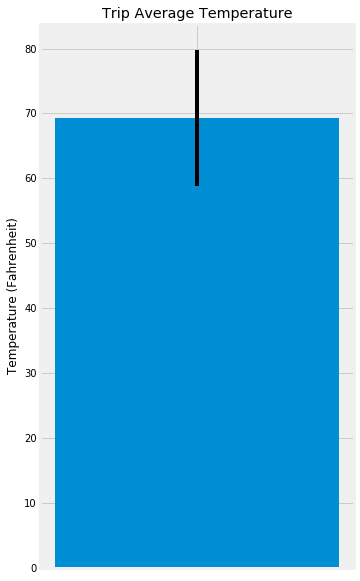

In [44]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
pk_to_pk = trip_temps[0][2] - trip_temps[0][0]
avg_temp = trip_temps[0][1]

fig, ax = plt.subplots(figsize = (5, 10))
ax.bar(1, avg_temp, yerr = pk_to_pk/2, width = 0.4)

ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Average Temperature')
ax.set_ylabel('Temperature (Fahrenheit)')

plt.show()

In [49]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's
#matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, 
#and elevation

weather_station_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

weather_station_rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.45064024390243923),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.19894886363636372),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.14142857142857151),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.12543396226415093),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.12105095541401273),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0765),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.044818941504178235)]